### Dataset: 
In this project, we are going to work with two datasets to implement Collaborative Filtering and Content-Based song recommendation system. 
Datasets: 

1- <b>MillionSongDataset (MSD):</b> 
We are working with a subset of this dataset(10k out of 350k)(http://millionsongdataset.com/pages/getting-dataset/)
It is possible to access the whole dataset by AWS, however it is not free. 
Although we are using the subset of this dataset, the code is <b><u>scalable</u></b>.
    
2- Implicit rating of 1million User(number of time a song played): http://millionsongdataset.com/tasteprofile/

#### Packages: 

In [110]:
import numpy as np
import pandas as pd
import tables   # Note: before installing pytables package, install HDF5, Numexpr, Cython, c-blosc packages
import h5py
import os
import fnmatch
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, Row
from pyspark import SparkContext
from pyspark.sql.types import *

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark_dist_explore import hist # install by "pip install pyspark_dist_explore"

from pyspark.sql.functions import col,isnan,when,count

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer

import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.feature import RobustScaler, StandardScaler


#### Create spark cluster: 

In [2]:
spark = SparkSession.builder.appName("Milion Songs Dataset").getOrCreate()
sc = SparkContext.getOrCreate()

#### path to datasets: 

In [3]:
data_MSD_path = 'MillionSongSubset'
data_impl_rating_path = 'train_triplets/train_triplets.txt'

### First dataset: 
#### Read the MSD dataset from HDF5 directories: 
- In order to read HDF5 file, HDFStore function of pandas library is used to read each .h5 file and keep in pyspark dataframe
- Each file(.h5) contains three keys <b>'/analysis/songs/', '/metadata/songs/', '/musicbrainz/songs/'
- Each key allow us to access data and metadata stored in the dataset 

- Easy method to walk through the directory and read files and append to spark dataframe while it is not efficient and scalable

#### Load the data in parallel with the help of spark RDD 

In [4]:
# load a sample of data to see the columns
hdf = pd.HDFStore(data_MSD_path+'/A/A/A/TRAAAAW128F429D538.h5',mode ='r', header = False)
df1 = hdf.get('/analysis/songs/')
df2 = hdf.get('/metadata/songs/')
df3 = hdf.get('/musicbrainz/songs/')
hdf.close()
sample_data_MSD = pd.concat([df1,df2,df3], axis = 1)
print(sample_data_MSD.T)

                                                                   0
analysis_sample_rate                                           22050
audio_md5                           a222795e07cd65b7a530f1346f520649
danceability                                                     0.0
duration                                                   218.93179
end_of_fade_in                                                 0.247
energy                                                           0.0
idx_bars_confidence                                                0
idx_bars_start                                                     0
idx_beats_confidence                                               0
idx_beats_start                                                    0
idx_sections_confidence                                            0
idx_sections_start                                                 0
idx_segments_confidence                                            0
idx_segments_loudness_max         

#### Extracting desirable features: 
Following columns are chosen to be used in this project. 

In [5]:
attribs=['song_id',
        'title', 
        'artist_id', 
        'duration',
        'key', 
        'loudness',
        'mode',
        'tempo',
        'time_signature',
        'song_hotttnesss', 
        'artist_hotttnesss', 
        'artist_familiarity', 
        'year'
       ] 

In [6]:

# This function is used in RDD to read each .h5 file and return a list of string(data of columns)
# f: directory path from spark.wholeTextFiles() function
# d: dataset directory path
def read_h5(f,d):
    # prune the file path is essential here, because the wholeTextFile function returns the absolute path
    hdf = pd.HDFStore(f[f.index(d):],mode ='r', header = False)  # Openning HDFStore to read .h5 file
    
    # The dataset is HDFS file with 3 main key {analysis, metadata, musicbrains} which 'songs' key allow us 
    # to access the data of each song(It should be mentioned that there are)  
    df1 = hdf.get('/analysis/songs/')
    df2 = hdf.get('/metadata/songs/')
    df3 = hdf.get('/musicbrainz/songs/')
    
    hdf.close()                                                  # Closing HDFStore  
    
    # concatenate all columns together in a dataframe and pick our desired features
    df_concat = pd.concat([df1,df2,df3], axis = 1)[attribs] 
    
    # return the result as a list of string to be able to store in rdd
    return df_concat.values.tolist()[0]


In [7]:
# find all path of all files without loading the files
rdd = sc.wholeTextFiles(data_MSD_path+'/*/*/*/*.h5').map(lambda x: read_h5(x[0],data_MSD_path))

In [9]:
rdd.first()

['SOMZWCG12A8C13C480',
 "I Didn't Mean To",
 'ARD7TVE1187B99BFB1',
 218.93179,
 1,
 -11.197,
 0,
 92.198,
 4,
 0.6021199899057548,
 0.4019975433642836,
 0.5817937658450281,
 0]

- As you see the first imported data to rdd is the same as the above sample (irrelevant columns are eliminated here)

Createing Spark dataframe from the RDD: 

In [8]:
# creating the schema for spark dataframe 
schema = StructType([
    StructField('song_id', StringType(), True),
    StructField('title', StringType(), True),
    StructField('artist_id', StringType(), True),
    StructField('duration', FloatType(), True),
    StructField('key', IntegerType(), True),
    StructField('loudness', FloatType(), True),
    StructField('mode', IntegerType(), True),
    StructField('tempo', FloatType(), True),
    StructField('time_signature', IntegerType(), True),
    StructField('song_hotttnesss', FloatType(), True),
    StructField('artist_hotttnesss', FloatType(), True),
    StructField('artist_familiarity', FloatType(), True), 
    StructField('year', IntegerType(), True)
])


In [9]:
data_MSD = spark.createDataFrame(rdd, schema)

In [16]:
# here the data is loaded to the memory 
data_MSD.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
duration,10000.0,238.507523,114.137512,1.044440,176.032196,223.059143,276.375061,1819.767700
key,10000.0,5.276100,3.554087,0.000000,2.000000,5.000000,8.000000,11.000000
loudness,10000.0,-10.485669,5.399788,-51.643002,-13.163250,-9.380000,-6.532500,0.566000
mode,10000.0,0.691100,0.462063,0.000000,0.000000,1.000000,1.000000,1.000000
tempo,10000.0,122.915451,35.184414,0.000000,96.965752,120.161003,144.013245,262.828003
time_signature,10000.0,3.564800,1.266239,0.000000,3.000000,4.000000,4.000000,7.000000
song_hotttnesss,5648.0,0.342822,0.247220,0.000000,0.000000,0.360371,0.537504,1.000000
artist_hotttnesss,10000.0,0.385552,0.143647,0.000000,0.325266,0.380742,0.453858,1.082503
artist_familiarity,9996.0,0.565456,0.160161,0.000000,0.467611,0.563666,0.668020,1.000000
year,10000.0,934.704600,996.650657,0.000000,0.000000,0.000000,2000.000000,2010.000000


DataFrame[song_id: string, title: string, artist_id: string, duration: float, key: int, loudness: float, mode: int, tempo: float, time_signature: int, song_hotttnesss: float, artist_hotttnesss: float, artist_familiarity: float, year: int]

### Second dataset:
#### Load User-Items(Music) dataset: 
- This dataset consists of three columns: userId, songId, and number of play for each song. 
- Consists of 1 Million user 
- Since the Million Song Dataset is a subset of all dataset(10000 songs) we should match songs of this dataset with the songs of above dataset

In [45]:
# define schema, nullable is set true
schema2 = StructType([
    StructField('userId', StringType(), True),
    StructField('songId', StringType(), True),
    StructField('play_count', IntegerType(), True)])

In [46]:
# read the file as a csv file which each coloumn is divided by a tab(in spark dataframe)
data_imp_rating = spark.read.option("delimiter", "\t").schema(schema2).csv(data_impl_rating_path) 

In [47]:
data_imp_rating.columns

['userId', 'songId', 'play_count']

In [21]:
data_imp_rating.describe().show()

+-------+--------------------+------------------+-----------------+
|summary|              userId|            songId|       play_count|
+-------+--------------------+------------------+-----------------+
|  count|            48373586|          48373586|         48373586|
|   mean|                null|              null|2.866858847305635|
| stddev|                null|              null|6.437724686877057|
|    min|00000b72200188206...|SOAAADD12AB018A9DD|                1|
|    max|fffff9534445f481b...|SOZZZWN12AF72A1E29|             9667|
+-------+--------------------+------------------+-----------------+



In [22]:
data_imp_rating.show(2)

+--------------------+------------------+----------+
|              userId|            songId|play_count|
+--------------------+------------------+----------+
|b80344d063b5ccb32...|SOAKIMP12A8C130995|         1|
|b80344d063b5ccb32...|SOAPDEY12A81C210A9|         1|
+--------------------+------------------+----------+
only showing top 2 rows



## Data Preprocessing: 
#### First dataset: 
##### dealing with null values

- Checking Null, empty, None, Nan values for each column: 

In [13]:
# Loop through all columns for each row and count: empty, None, Null, Nan 
ps_df = data_MSD.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), 
                                      c )).alias(c) for c in data_MSD.columns])


In [ ]:
pdd = ps_df.toPandas()

In [ ]:
pdd

Based on the result, song_hotttnesss feature has huge amount of null values. Thus we decide to not use this feature and remove the column. 
Title feature has only 2 missing values, since we are not going to work with this feature it is left untouch. 
For the artist_familiarity feature we just remove 4 missing values. 
Year feature: By looking at the describtion of the dataset, min value is 0, which is not valid. Thus, we need to investigate more and count the zero values. 

In [14]:
data_MSD.filter(data_MSD['year'] == '0').count()

5320

- Since the number of 0 values in year are too much and it is better to remove this feature: 

In [18]:
data_MSD = data_MSD.drop("year")

- The same for song_hotttnesss

In [19]:
data_MSD = data_MSD.drop("song_hotttnesss")

- Remove null values of artist_familiarity:

In [20]:
data_MSD = data_MSD.dropna(subset=['artist_familiarity'],how='all')

Making sure the changes being applied: 

In [ ]:
ps_df = data_MSD.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), 
                                      c )).alias(c) for c in data_MSD.columns])

In [31]:
pdd = ps_df.toPandas()

In [32]:
pdd

,song_id,title,artist_id,duration,key,loudness,mode,tempo,time_signature,artist_hotttnesss,artist_familiarity
0,0,2,0,0,0,0,0,0,0,0,0


#### Plotting all features: 

C:\Users\reza\AppData\Local\Temp\ipykernel_2528\2174606417.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_MSD.toPandas().hist(ax = ax)


array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'time_signature'}>],
       [<AxesSubplot:title={'center':'artist_hotttnesss'}>,
        <AxesSubplot:title={'center':'artist_familiarity'}>,
        <AxesSubplot:>]], dtype=object)

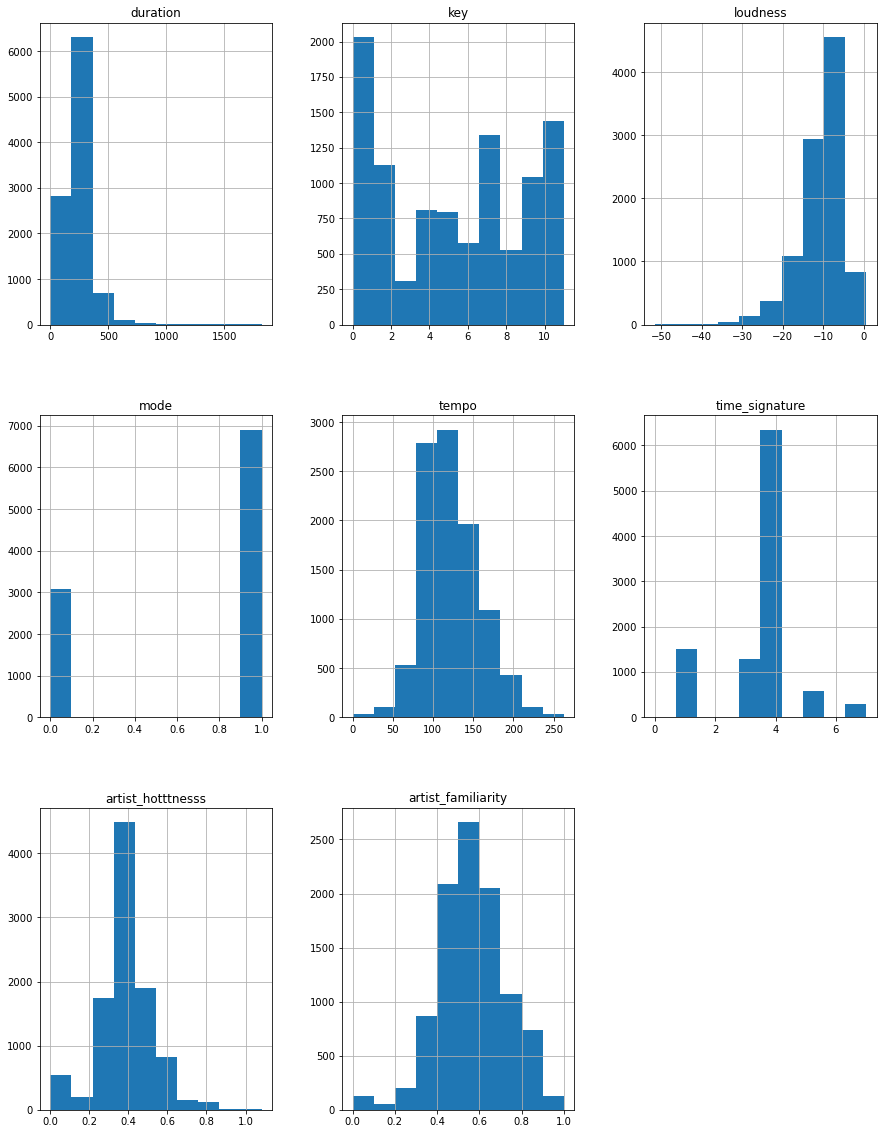

In [39]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data_MSD.toPandas().hist(ax = ax)

#### Now we can decide whether to apply normalization, standardization or both to the data.  
standardization: Dealing with outliers by using IQR method

normalization: Scale data between 0-1
- <b>duration</b>: Obviously we need both here because data is more concentrated between 0 and 500 and we have some outliers above 500 which can be addressed by standardization. 
    To scale the data between 0-1, normalization can be applied. 
- <b>key</b>: it is evenly distributed from 0 to 11 and we only apply normalization here to scale it between 0-1
- <b>loudness</b>: Same as the duration feature, we have some outliers from -50 to -30 which can be solved by standardization. Normalization will be applied too. 
- <b>mode</b>: Since this value is either 0 or 1, neither normalization is needed nor standardization 
- <b>tempo</b>: Since data is symmetrically distributed here we can overlook standardization. However, we apply it on the data to get rid of outliers on its head and tail. 
- <b>time_signature</b>: Just normalization 
- <b>artist_hottness</b>: Because data distribution is not sparse, no standardization,but normalization to make sure data is between 0-1
- <b>artist_familiarity</b>: the same as artist_hottness
    

In [21]:
data_MSD.persist()

DataFrame[song_id: string, title: string, artist_id: string, duration: float, key: int, loudness: float, mode: int, tempo: float, time_signature: int, artist_hotttnesss: float, artist_familiarity: float]

##### Standardardizer method: 

In [214]:
# standardize a column with IQR method
def standardize(df, column : str, lower, upper): 
    
    split_udf = udf(lambda x: float(list(x)[0].item()), DoubleType())
    
    # create a vector assembler
    assembler = VectorAssembler(inputCols=[column], outputCol='temp')
    
    # assembel the vector to dataframe 
    df = assembler.transform(df) # add temp column 
    
    scaler = RobustScaler(inputCol = 'temp',outputCol='stndr',withScaling= True, withCentering=False,lower=lower, upper=upper)
    
    # Compute summary statistics by fitting the RobustScaler
    scalerModel = scaler.fit(df) 
    
    # Transform each column to have unit quantile range.    
    df = scalerModel.transform(df)
    
    # drop the created columns and substitute with the old column
    df = df.drop(column,'temp')
    df = df.withColumn('stndr',split_udf(col('stndr')))
    df = df.withColumnRenamed('stndr', column)
    return df , scalerModel
    


#### Normalizer method: 

In [219]:
def normalizer(df , column): 
    # UDF for converting column type from vector to double type
    split_udf = udf(lambda x: float(list(x)[0].item()), DoubleType())

    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[column],outputCol='temp')
    df = assembler.transform(df)
    
    # MaxMinScaler to scale between 0-1
    scaler = MinMaxScaler(inputCol='temp', outputCol='normalized')

    scalerModel = scaler.fit(df)
    df = scalerModel.transform(df)
    
    # drop the created columns and substitute with the old column
    df = df.drop(column,'temp')
    df = df.withColumn('normalized',split_udf(col('normalized')))
    df = df.withColumnRenamed('normalized', column)
    
    return df , scalerModel

##### Standardize following features:

'duration', 'key', 'loudness', 'mode', 'tempo', 'time_signature', 'artist_hotttnesss', 'artist_familiarity

In [216]:
scalers_stdr = {'duration': None, 
          'loudness': None,
          'tempo': None}

In [217]:
data_MSD_scaled = data_MSD
data_MSD_scaled , scalers_stdr['duration'] = standardize(data_MSD_scaled, 'duration', 0.05, 0.75)
print('Standardizing feature: '+ 'duration' )

data_MSD_scaled , scalers_stdr['loudness'] = standardize(data_MSD_scaled, 'loudness', 0.2, 0.90)
print('Standardizing feature: '+ 'loudness' )

data_MSD_scaled , scalers_stdr['tempo'] = standardize(data_MSD_scaled, 'tempo', 0.20, 0.85)
print('Standardizing feature: '+ 'tempo' )


Standardizing feature: duration
Standardizing feature: loudness
Standardizing feature: tempo


C:\Users\reza\AppData\Local\Temp\ipykernel_6448\3078121536.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_MSD_scaled.toPandas().hist(ax = ax)


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'time_signature'}>],
       [<AxesSubplot:title={'center':'artist_hotttnesss'}>,
        <AxesSubplot:title={'center':'artist_familiarity'}>,
        <AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'tempo'}>, <AxesSubplot:>]],
      dtype=object)

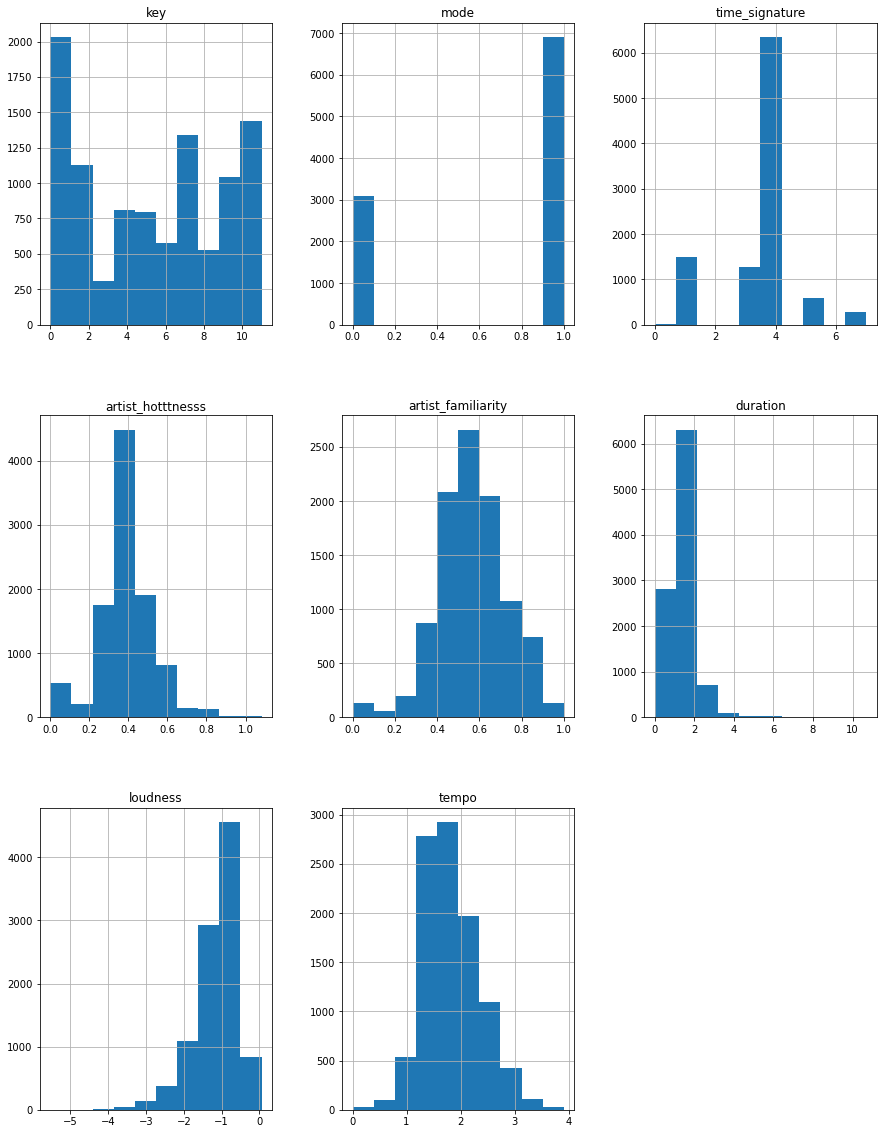

In [218]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data_MSD_scaled.toPandas().hist(ax = ax)

In [209]:
data_MSD_scaled.toPandas().describe(percentiles=[0.05,.1, .2, .5, .7, .8, .9,.95]).T

,count,mean,std,min,5%,10%,20%,50%,70%,80%,90%,95%,max
key,9996.0,5.276611,3.554199,0.000000,0.000000,0.000000,1.000000,5.000000,8.000000,9.000000,10.000000,11.000000,11.000000
mode,9996.0,0.690976,0.462114,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
time_signature,9996.0,3.564626,1.266462,0.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,4.000000,5.000000,7.000000
artist_hotttnesss,9996.0,0.385707,0.143469,0.000000,0.049034,0.257063,0.311438,0.380756,0.434411,0.476761,0.547755,0.601186,1.082503
artist_familiarity,9996.0,0.565456,0.160161,0.000000,0.321843,0.379428,0.441050,0.563666,0.637508,0.697113,0.784970,0.839275,1.000000
duration,9996.0,238.518765,114.157658,1.044440,105.632202,135.274643,165.459137,223.059143,262.921997,291.578308,350.353821,421.700775,1819.767700
loudness,9996.0,-10.488092,5.399337,-51.643002,-20.931750,-17.424500,-14.253000,-9.382000,-7.057000,-6.020000,-4.897000,-4.026250,0.566000
tempo,9996.0,122.910529,35.183146,0.000000,74.134251,84.819500,92.884003,120.161003,138.030502,151.272995,169.888000,186.496498,262.828003


In [210]:
data_MSD.toPandas().describe(percentiles=[0.05,.1, .2, .5, .7, .8, .9,.95]).T

,count,mean,std,min,5%,10%,20%,50%,70%,80%,90%,95%,max
duration,9996.0,238.518753,114.157654,1.044440,105.632202,135.274643,165.459137,223.059143,262.921997,291.578308,350.353821,421.700775,1819.767700
key,9996.0,5.276611,3.554199,0.000000,0.000000,0.000000,1.000000,5.000000,8.000000,9.000000,10.000000,11.000000,11.000000
loudness,9996.0,-10.488092,5.399337,-51.643002,-20.931750,-17.424500,-14.253000,-9.382000,-7.057000,-6.020000,-4.897000,-4.026250,0.566000
mode,9996.0,0.690976,0.462114,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
tempo,9996.0,122.910530,35.183147,0.000000,74.134251,84.819500,92.884003,120.161003,138.030502,151.272995,169.888000,186.496498,262.828003
time_signature,9996.0,3.564626,1.266462,0.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,4.000000,5.000000,7.000000
artist_hotttnesss,9996.0,0.385707,0.143469,0.000000,0.049034,0.257063,0.311438,0.380756,0.434411,0.476761,0.547755,0.601186,1.082503
artist_familiarity,9996.0,0.565456,0.160161,0.000000,0.321843,0.379428,0.441050,0.563666,0.637508,0.697113,0.784970,0.839275,1.000000


#### Now its time for Normalization: 

In [220]:
scalers_norm = {'duration': None, 
          'key': None, 
          'loudness': None,
          'mode': None, 
          'tempo': None, 
          'time_signature': None, 
          'artist_hotttnesss': None,
          'artist_familiarity': None}

In [221]:
for i in scalers_norm.keys(): 
    data_MSD_scaled , scalers_norm[i] = normalizer(data_MSD_scaled, i)
    print('Normalizing feature: '+ i )

Normalizing feature: duration
Normalizing feature: key
Normalizing feature: loudness
Normalizing feature: mode
Normalizing feature: tempo
Normalizing feature: time_signature
Normalizing feature: artist_hotttnesss
Normalizing feature: artist_familiarity


C:\Users\reza\AppData\Local\Temp\ipykernel_6448\3078121536.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_MSD_scaled.toPandas().hist(ax = ax)


array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'time_signature'}>],
       [<AxesSubplot:title={'center':'artist_hotttnesss'}>,
        <AxesSubplot:title={'center':'artist_familiarity'}>,
        <AxesSubplot:>]], dtype=object)

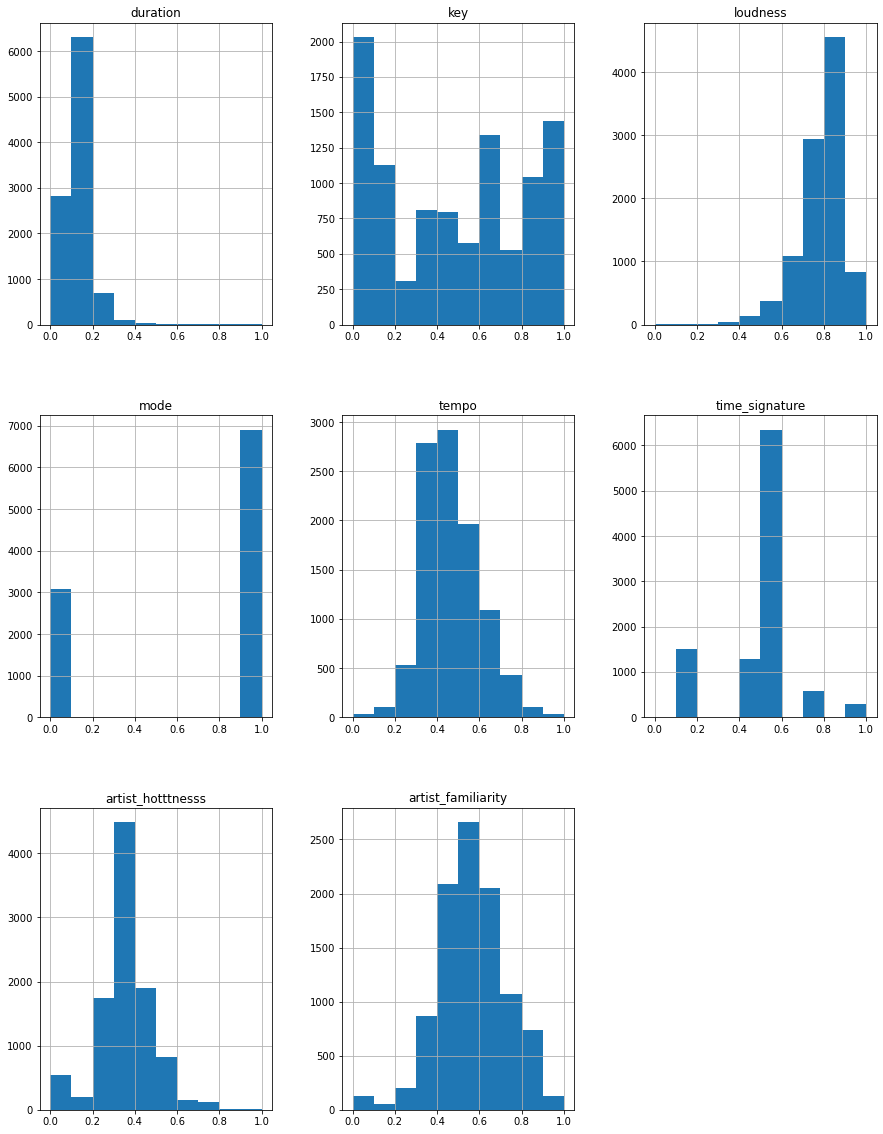

In [222]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data_MSD_scaled.toPandas().hist(ax = ax)

In [191]:
data_MSD_scaled.toPandas().describe(percentiles=[0.05,.1, .2, .5, .7, .8, .9,.95]).T

,count,mean,std,min,5%,10%,20%,50%,70%,80%,90%,95%,max
duration,9996.0,0.130572,0.062768,0.0,0.057506,0.073805,0.090401,0.122072,0.143990,0.159746,0.192063,0.231292,1.0
key,9996.0,0.479692,0.323109,0.0,0.000000,0.000000,0.090909,0.454545,0.727273,0.818182,0.909091,1.000000,1.0
loudness,9996.0,0.788272,0.103418,0.0,0.588237,0.655414,0.716160,0.809458,0.853991,0.873853,0.895363,0.912041,1.0
mode,9996.0,0.690976,0.462114,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
tempo,9996.0,0.467646,0.133864,0.0,0.282064,0.322719,0.353402,0.457185,0.525174,0.575559,0.646385,0.709576,1.0
time_signature,9996.0,0.509232,0.180923,0.0,0.142857,0.142857,0.428571,0.571429,0.571429,0.571429,0.571429,0.714286,1.0
artist_hotttnesss,9996.0,0.356310,0.132534,0.0,0.045297,0.237471,0.287702,0.351737,0.401303,0.440425,0.506008,0.555367,1.0
artist_familiarity,9996.0,0.565456,0.160161,0.0,0.321843,0.379428,0.441050,0.563666,0.637508,0.697113,0.784970,0.839275,1.0


#### Second dataset (user/songs/play-count): 
- Since we are using a subset of songs dataset(MSD subset), it is possible that some songs in User-Songs dataset not to be in the MSD dataset. To make sure we are going to keep only songs in the MSD dataset with leftsemi join method, as follows: 

In [34]:
data_imp_rating.count()

48373586

In [35]:
data_imp_rating = data_imp_rating.join(data_MSD, data_imp_rating.songId ==  data_MSD.song_id, "leftsemi")

In [36]:
data_imp_rating.count()

772661

In [37]:
data_imp_rating.describe().show()

+-------+--------------------+------------------+-----------------+
|summary|              userId|            songId|       play_count|
+-------+--------------------+------------------+-----------------+
|  count|              772661|            772661|           772661|
|   mean|                null|              null|2.684340221649598|
| stddev|                null|              null| 5.45464579821813|
|    min|00001638d61892368...|SOAAAQN12AB01856D3|                1|
|    max|fffff67d54a40927c...|SOZZVMW12AB0183B52|              771|
+-------+--------------------+------------------+-----------------+



#### Normalizing songs features: 

## Content-Based Recommendation System: 

In [35]:
data_MSD.columns

['song_id',
 'title',
 'artist_id',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [37]:
data_MSD_features = ['duration',
                     'key', 
                     'loudness',
                     'mode',
                     'tempo',
                     'time_signature',
                     'artist_hotttnesss', 
                     'artist_familiarity']

In [38]:
temp_name = ['sum(duration)',
             'sum(key)', 
             'sum(loudness)',
             'sum(mode)',
             'sum(tempo)',
             'sum(time_signature)',
             'sum(artist_hotttnesss)', 
             'sum(artist_familiarity)']

In [59]:
# add songs features to implicit dataset(user-song-plays)
user_profile = data_MSD.join(data_imp_rating, data_MSD.song_id == data_imp_rating.songId )

In [60]:
user_profile.columns

['song_id',
 'title',
 'artist_id',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity',
 'userId',
 'songId',
 'play_count']

In [62]:
# calculate the product of each feature with play_count column  
for x in data_MSD_features:
    user_profile = user_profile.withColumn(x, col(x)*col('play_count'))
    
user_profile = user_profile.groupby('userId').sum('duration',
                                                  'key', 
                                                  'loudness',
                                                  'mode',
                                                  'tempo',
                                                  'time_signature',
                                                  'artist_hotttnesss', 
                                                  'artist_familiarity')


In [63]:
user_profile.columns

['userId',
 'sum(duration)',
 'sum(key)',
 'sum(loudness)',
 'sum(mode)',
 'sum(tempo)',
 'sum(time_signature)',
 'sum(artist_hotttnesss)',
 'sum(artist_familiarity)']

In [65]:
#changing the columns name same as songs dataset columns 
for x,y in zip(data_MSD_features,temp_name):
    user_profile = user_profile.withColumnRenamed(y,x)

In [66]:
user_profile.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [71]:
# add a column to store the sum of feature for each user 
user_profile= user_profile.withColumn('sum', sum(user_profile[col] for col in data_MSD_features ))

# calculate the user interest probability to each feature (feature_value / sum of the value of all features) 
for x in data_MSD_features:
    user_profile= user_profile.withColumn(x, col(x)/col('sum'))

In [72]:
user_profile.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity',
 'sumall',
 'sum']

Now the user profile is created based on songs he/she played!! 

<b>Now everything is ready to evaluate most similar songs to a user. </b>

In [ ]:
#### Calculate similarity: (in user_profile and songs dataset, data_MSD)


## ALS Implementation: 
### Convert userIds and songIds from string to integer: 
Since ALS algorithm accepts integer type as user and item id, here, we convert them to integer by stringIndexer class.  

In [22]:
userIndexer = StringIndexer(inputCol='userId', outputCol='userIndex').fit(data_imp_rating)
songIndexer = StringIndexer(inputCol='songId', outputCol='songIndex').fit(data_imp_rating)

 Pipeline class provides us accessibility of multiple Transformers and Estimators of Machine Learning. 

In [23]:
pipeline = Pipeline(stages=[userIndexer, songIndexer])
data_imp_rating = pipeline.fit(data_imp_rating).transform(data_imp_rating)

In [24]:
data_imp_rating.show(5)

+--------------------+------------------+----------+---------+---------+
|              userId|            songId|play_count|userIndex|songIndex|
+--------------------+------------------+----------+---------+---------+
|4e2e58dd3e4655184...|SOCKUUJ12A6D4FA41C|         1|  53252.0|    147.0|
|9b400e47e6c4303a9...|SOCKUUJ12A6D4FA41C|         1| 136450.0|    147.0|
|7c215e1d94585e686...|SOCKUUJ12A6D4FA41C|         1| 125168.0|    147.0|
|79eca33172405b2f7...|SOCKUUJ12A6D4FA41C|         1|   2663.0|    147.0|
|adbe4cdb34bc5f3fd...|SOCKUUJ12A6D4FA41C|         2| 143159.0|    147.0|
+--------------------+------------------+----------+---------+---------+
only showing top 5 rows



In [26]:
(training, test) = data_imp_rating.randomSplit([0.8, 0.2])

In [1]:
# ALS Algorithm to fill null values
# Build the recommendation model using ALS on the training data
# Rating is implicit in our model, it is biased too, so the implicitPrefs assigned true to add biased terms to the algorithm
# In this step we are not dealing with cold-start issues so the coldStartStrategy is droped

als = ALS(maxIter=5, 
          regParam=0.1, 
          userCol="userIndex", 
          itemCol="songIndex", 
          ratingCol="play_count",
          implicitPrefs = True,
          coldStartStrategy="drop")

model_CF = als.fit(training)




In [ ]:
predictions = model.transform(test)

In [ ]:
# Evaluate the model by computing RMSE
evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="play_count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE error = " + str(rmse))


In [ ]:
# Generate top 10 songs recommendations
userRecs = model.recommendForAllUsers(5)

### (In-case we need) Cross validation for hyperparameters: 